# 3'READS+ Pipeline (Part 3)

**This notebook is the Part 3 of the 3'READS+ pipeline, which will do machine learning in the following steps:**
1. Prepare data
2. Select the most promising models using cross validation
3. Fine tune hyper parameters of the support vector machine (SVM) model
4. Fine tune hyper parameters of the gradient boosting tree (XGboost) model
5. Model interpretation

**Required softwares**
* Python packages: pathlib, np, pandas, altair, sklern, XGboost, shap, etc
* Jupyter Lab or Jupyter Notebook for running this notebook
* Linux environment

## 1. Prepare data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import altair as alt

## 1.1. Load data

In [4]:
# Project directory
exp_dir = Path('..')
PROJECT, EXPERIMENT = exp_dir.cwd().parts[-3:-1]
SETTING = 'NC'

# Result directory
result_dir = exp_dir/'results'/SETTING

df = pd.read_csv(result_dir/'pas.csv')

Uncomment the following line to see column names:

In [5]:
# df.columns.values

## 1.2. Prepare data

Select useful columns. I will use size, GC%, RNA structure, and RBP binding score features to predict nuclear cytoplasmic ratio of alternative polyadenylation isoform-specific RNA.

In [6]:
df = (df
      .loc[df['region']=='3UTR']
      .filter(regex='intron|_size$|_GC$|_mfe_|RBP|NT_N_C_FC|gene_symbol|pAid')
      .drop(df.filter(regex='ncRNA|has_intron').columns, axis=1)
      .replace([np.inf, -np.inf], np.nan)
      .dropna(axis=0, how="any")
      )
df = df.set_index(['gene_symbol', 'pAid'])

Uncomment the following line to see null values:

In [7]:
# df.isnull().sum()

Uncomment the following line to see description of the columns:

In [8]:
# Have a quick look at the data frame
# pd.set_option('display.max_rows', 10)
# df.describe().T

Uncomment the following line to see data types of the columns:

In [9]:
# df.dtypes
# df.info()

Set data types if necessary:

In [10]:
df = pd.concat([df.filter(regex='^num_|_size$').astype('int64'), 
                df.drop(df.filter(regex='^num_|_size$').columns, axis=1)], 
                axis=1)

## 1.3. Define training and testing data sets

In [11]:
# Using X to predict y:
X = df.drop(columns=['NT_N_C_FC']).copy()
y = df['NT_N_C_FC'].copy()

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 2. Select the most promising models with cross validation

## 2.1. Set up transformers

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Although transformations are not necessary for tree-based models, 
# they are necessary for linear models and SVM models.
float_features = X_train.select_dtypes(include=['float64']).columns
integer_features = X_train.select_dtypes(include=['int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# float_features
# integer_features
# categorical_features

float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

integer_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_scaler', PowerTransformer()),
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
                   transformers=[
                       ('flt', float_transformer, float_features),
                       ('int', integer_transformer, integer_features),
                       ('cat', categorical_transformer, categorical_features)
                   ]
               )

## 2.2. Set up regressors

In [14]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

regressors = [
    LinearRegression(),
    Ridge(),
    SVR(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(objective='reg:squarederror')
    ]

## 2.3. Train the models with default hyper parameters

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

results = {}

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, n_jobs=-1)
    results[regressor.__class__.__name__] = cv_results

results = pd.DataFrame(results).rename_axis('K').reset_index()
results = results.melt('K', var_name='Model', value_name='Score')

# results['Mean'] = results.groupby('Model', as_index=False)['Score'].transform(np.mean)
# results = results.sort_values('Mean')

## 2.4. Compare different models

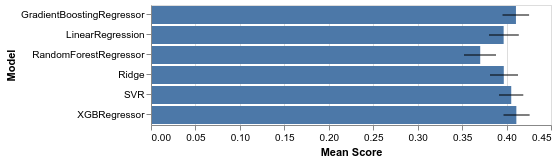

In [16]:
import altair as alt
bars = alt.Chart(results).mark_bar().encode(
    x=alt.X('mean(Score):Q', title='Mean Score'),
    y=alt.Y('Model:N', sort=alt.EncodingSortField(op='mean', field='Score', order='descending'))
)
error_bars = bars.mark_errorbar(extent='ci').encode(
    x=alt.X('Score:Q', title='Mean Score')
)

bars + error_bars

We can see that with default parameters, gradient boosting tree models have better performance than other models. However, the performance of support vector machine model is quite close. Therefore I'll fine tune the support vector machine model (SVR) and one of the boosting tree model (XGBRegressor). I will not fine tune the GradientBoostingRegressor model, because its slower than the XGBRegressor. 

## 3.1. Fine tune the support vector machine model

In [41]:
svr = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

param_grid = { 
    'regressor__C': [0.1, 0.25, 0.5, 0.75, 1],
    'regressor__epsilon':[0.05, 0.1, 0.2, 0.25, 0.3],
}

from sklearn.model_selection import GridSearchCV
svr_search = GridSearchCV(svr, param_grid, n_jobs= -1, cv=3, verbose=1, return_train_score=True)
                  
svr_search.fit(X_train, y_train)  

print(svr_search.best_params_)    
print(svr_search.best_score_)
print(svr_search.score(X_test, y_test))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  4.7min finished


{'regressor__C': 0.5, 'regressor__epsilon': 0.2}
0.3992051224486267
0.3649489658559991


Save model:

In [68]:
import pickle
pickle.dump(svr_search.estimator, (result_dir/'svr_model.pkl').open('wb'))

# To load
# svr_model = pickle.load((result_dir/'svr_model.pkl').open('rb')) 

## 3.2. Fine tune the gradient boosting tree (xgboost) model

In [42]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor(objective='reg:squarederror')

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 8), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=1, 
                              n_iter=400, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

xgb_search.fit(X_train, y_train)

print(xgb_search.best_params_)    
print(xgb_search.best_score_)
print(xgb_search.score(X_test, y_test))

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 27.0min finished


{'colsample_bytree': 0.9816135099113559, 'gamma': 0.18556695047773414, 'learning_rate': 0.04500542576647279, 'max_depth': 6, 'n_estimators': 134, 'subsample': 0.681743251144754}
0.41891538567071257
0.3932941638924379


Save model:

In [69]:
pickle.dump(xgb_search.estimator, (result_dir/'xgb_model.pkl').open('wb'))

# To load
# xgb_model = pickle.load((result_dir/'xgb_model.pkl').open('rb')) 

## 3.3. Plot prediction vs observation for the training data

In [43]:
Yy = pd.DataFrame({'Observed':y_train, 
                   'Predicted by SVM':svr_search.predict(X_train),
                   'Predicted by XGboost':xgb_search.predict(X_train),
                   })

Yy = Yy.reset_index()

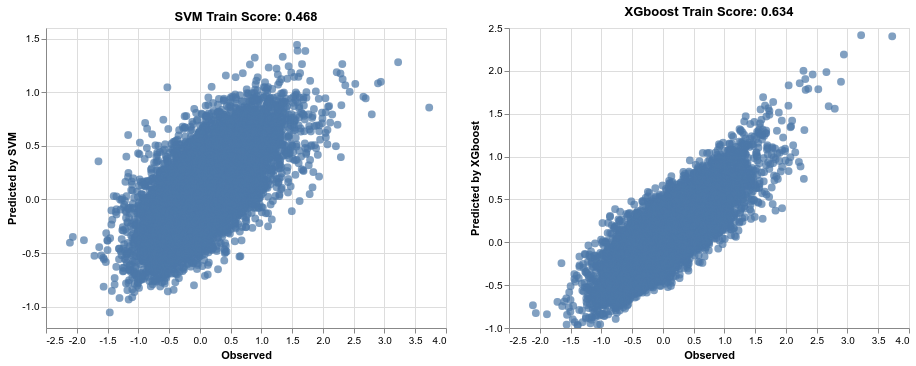

In [44]:
alt.data_transformers.disable_max_rows()

p1 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by SVM',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'SVM Train Score: {svr_search.score(X_train, y_train):.3f}'
).interactive()

p2 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by XGboost',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'XGboost Train Score: {xgb_search.score(X_train, y_train):.3f}'
).interactive()

(p1 | p2)

## 3.4. Plot prediction vs observation for the testing data

In [45]:
Yy = pd.DataFrame({'Observed':y_test, 
                   'Predicted by SVM':svr_search.predict(X_test),
                   'Predicted by XGboost':xgb_search.predict(X_test),
                   })

Yy = Yy.reset_index()

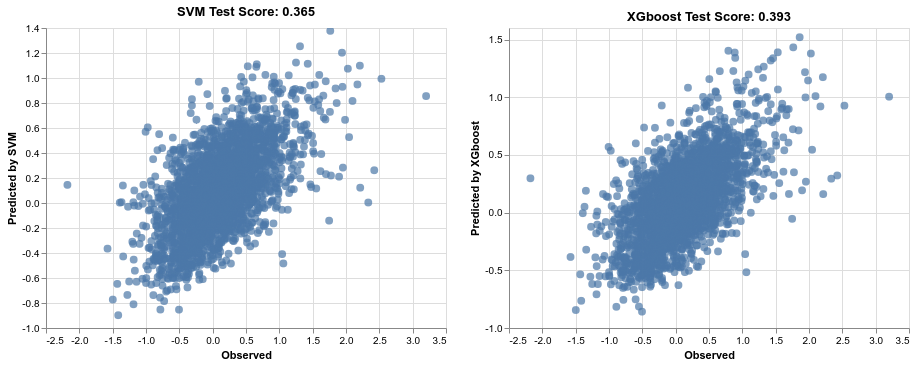

In [46]:
p1 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by SVM',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'SVM Test Score: {svr_search.score(X_test, y_test):.3f}'
).interactive()

p2 = alt.Chart(Yy).mark_circle(size=60).encode(
    y='Predicted by XGboost',
    x='Observed',
    tooltip = ['gene_symbol', 'pAid']
).properties(
    title=f'XGboost Test Score: {xgb_search.score(X_test, y_test):.3f}'
).interactive()

(p1 | p2)

We can see that after fine tunning the XGboost model still has a higher score than the support vector machine model when tested on the test data set. Therefore I will focus on the XGboost model to interpret the importance of different features.

## 4. Model interpretation 
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.

In [47]:
import shap
explainer = shap.TreeExplainer(xgb_search.estimator.fit(X_train, y_train))
shap_values = explainer.shap_values(X_train)

## 4.1. Plot feature importance:

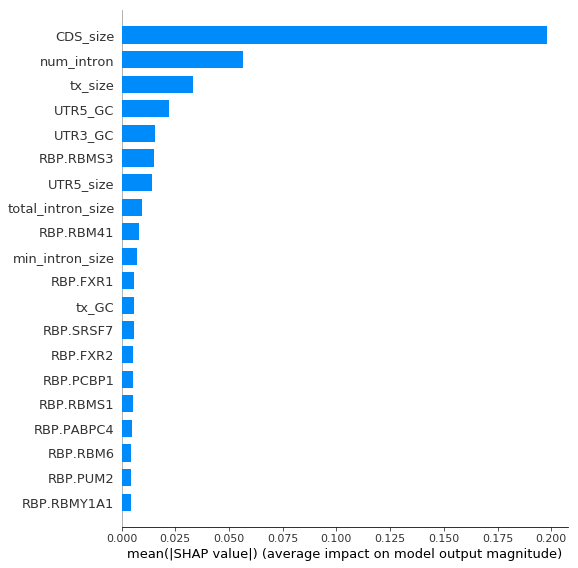

In [48]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## 4.2. Summarize how different feature values impact the predicted values:

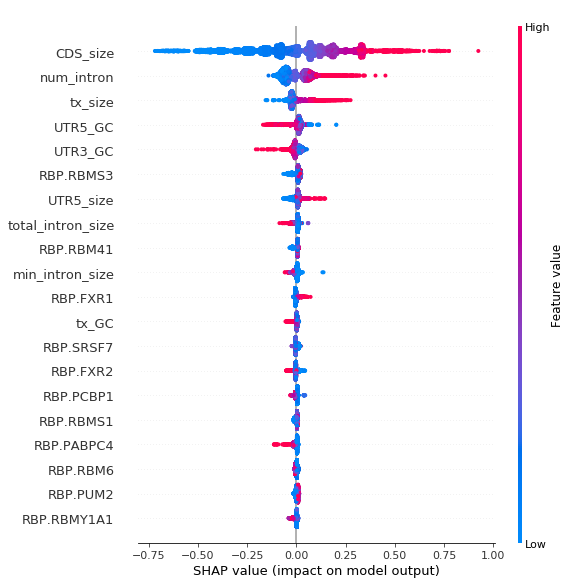

In [49]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

## 4.3. Plot how individual feature impacts the predicted values:

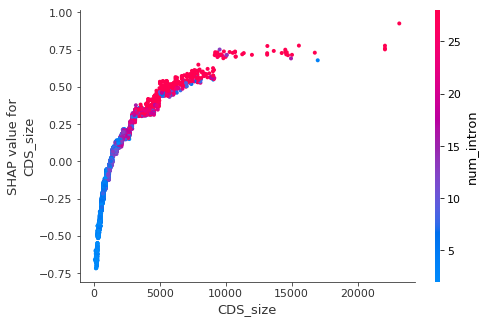

In [50]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("CDS_size", shap_values, X_train)

Clearly we can see that as the CDS size increases, the prediction increases. Large CDS size is also correlated with high intron numbers.

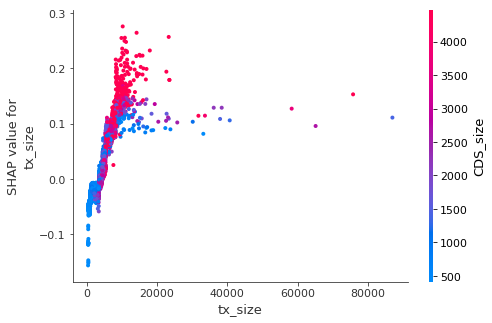

In [51]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("tx_size", shap_values, X_train)

In [53]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("UTR5_GC", shap_values, X_train, interaction_index='UTR3_GC')

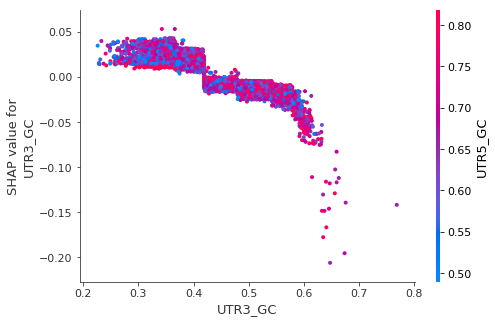

In [54]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("UTR3_GC", shap_values, X_train, interaction_index='UTR5_GC')

5'UTR and 3'UTR GC% seems to be negatively correlated with predicted contribution to log2(Nuclear/Cytoplasm).

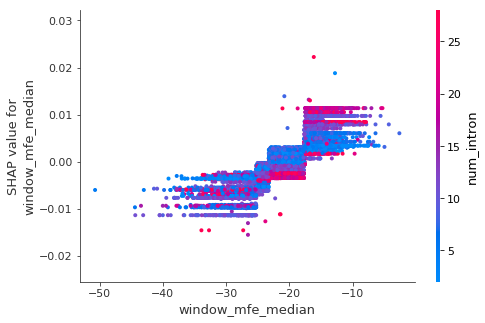

In [55]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("window_mfe_median", shap_values, X_train)

## 4.4. Plot feature interaction

In [56]:
from pdpbox import pdp
feats = ['CDS_size', 'tx_size']
p = pdp.pdp_interact(xgb_search.estimator, X_train, 
                     X_train.columns, feats, num_grid_points=[20, 20])
pdp.pdp_interact_plot(p, feats, x_quantile=True, figsize=(10, 12));

Compared with CDS size, transcript size does not matter much.

In [57]:
feats = ['CDS_size', 'num_intron']
p = pdp.pdp_interact(xgb_search.estimator, X_train, 
                     X_train.columns, feats, num_grid_points=[20, 20])
pdp.pdp_interact_plot(p, feats, x_quantile=True, figsize=(10, 12));

It seems that high number of introns can compensate for not so high CDS size.

In [61]:
feats = ['UTR5_GC', 'UTR3_GC']
p = pdp.pdp_interact(xgb_search.estimator, X_train, 
                     X_train.columns, feats, num_grid_points=[20, 20])
pdp.pdp_interact_plot(p, feats, x_quantile=True, figsize=(10, 12));

## 4.5. Plot how individual feature impacts prediction for individual genes:
If the gene has APA isoforms, they will all be plotted.

In [58]:
def explain_gene(m=xgb_search.estimator, X=X_train, y=y_train, symbol='Timp2'):
    import shap
    shap.initjs()
    explainer = shap.TreeExplainer(m.fit(X, y))
    shap_values = explainer.shap_values(X)
    idx = (X.reset_index()['gene_symbol'] == symbol)
    idx = np.where(idx)
    
    for i in idx[0]:
        p = shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:], 
                            out_names=symbol+','+X.reset_index().loc[i,'pAid'])
        display(p)

In [59]:
explain_gene(symbol='Col12a1')

We can see that Col12a1 has one 3'UTR APA isoform. It is predicted to have a high log2(Nuclear/Cytoplasm) score (1.42), which is much higher than the base value (0.1069), because it has a large CDS size and high number of introns.

In [60]:
explain_gene(symbol='Timp2')

We can see that Timp2 has three 3'UTR APA isoforms, all of which are predicted to have low log2(Nuclear/Cytoplasm) scores (< 0.10), which are lower than the base value (0.1069), because they have small CDS size and low number of introns.

Because github won't display the above javascript plots, I'm posting a screenshot here:
![explain_genes](../../../../images/explain_genes.png)

## Summary: 
It seems that transcripts with large CDS size and/or high number of introns tend to be more enriched in the nucleus than in the cytoplasm. Transcripts with low 5'UTR and 3'UTR GC% also tend to be slightly more enriched in the nucleus. However, we have to remember that our best model (XGboost) can only explain about 44% of the variance observed in the test data set. Moreover, although tree-based models are not sensitive to correlated features during inference, they can still incorrectly calculate the importance of correlated features. In this analysis, CDS size is correlated with transcript size while CDS GC% is correlated with 3'UTR GC%. Therefore their importance may be miss calculated.